# Selection Bias

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az
import xarray as xr

from utils import value_counts, decorate

from scipy.special import expit


In [3]:
# Make the figures smaller to save some screen real estate
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]
plt.rcParams["axes.titlelocation"] = "left"

## Robust version

Data from https://fairnessmeasures.github.io/Pages/DatasetPages/SAT.html

Zehlike, Meike, Carlos Castillo, Francesco Bonchi, Ricardo Baeza-Yates, Sara Hajian, Mohamed Megahed. “Fairness Measures: Datasets and software for detecting algorithmic discrimination.” June, 2017. http://fairness-measures.org/ [bibtex]

Ultimately from:

2011 math: https://secure-media.collegeboard.org/digitalServices/pdf/SAT-Mathemathics_Percentile_Ranks_2011.pdf

2011 writing: https://secure-media.collegeboard.org/digitalServices/pdf/SAT-Writing_Percentile_Ranks_2011.pdf

2012 mathematics: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Mathemathics-Percentile-Ranks-2012.pdf

2011 composite: https://secure-media.collegeboard.org/digitalServices/pdf/SAT-Percentile-Ranks-Composite-CR-M-W-2011.pdf

https://secure-media.collegeboard.org/digitalServices/pdf/SAT-Percentile-Ranks-Composite-CR-M_2011.pdf

2012 reading: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Critical-Reading-Percentile-Ranks-2012.pdf

2012 composite: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Percentile-Ranks-Composite-CR-M-W-2012.pdf

https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Percentile-Ranks-Composite-CR-M-2012.pdf

2013 composite: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Percentile-Ranks-Composite-CR-M-W-2013.pdf

https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Percentile-Ranks-Composite-CR-M-2013.pdf

https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Percentile-Ranks-Composite-CR-M-W-2013.pdf

2013 mathematics: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Mathematics-Percentile-Ranks-2013.pdf

2013 reading: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Critical-Reading-Percentile-Ranks-2013.pdf

2014: https://web.archive.org/web/20160402182221/https://secure-media.collegeboard.org/digitalServices/pdf/sat/sat-percentile-ranks-mathematics-2014.pdf

2015: https://web.archive.org/web/20211222094405/https://secure-media.collegeboard.org/digitalServices/pdf/sat/sat-percentile-ranks-mathematics-2015.pdf

2016: 



In [4]:
!tail sat-percentile-ranks-mathematics-2015-Group-Data.csv

1681146;1682924;240;1779;;1
1682925;1685217;240;2293;1;1
1685218;1686643;230;1426;;1
1686644;1688534;230;1891;1;1
1688535;1689529;220;995;;1_
1689530;1690889;220;1360;1;1_
1690890;1691960;210;1071;;1_
1691961;1693356;210;1396;1;1_
1693357;1695812;200;2456;;�
1695813;1698521;200;2709;1;�

In [54]:
sat_2014 = pd.read_csv('sat-percentile-ranks-mathematics-2014-group-data.csv', 
                      sep=';', encoding='cp1252')
sat_2014.head()

,from,to,score,delta,sex,Percentile (w respect to sex)
0,1,9835,800,9835,0,99
1,9836,14677,800,4842,1,99
2,14678,17098,790,2421,0,98
3,17099,18505,790,1407,1,99
4,18506,20061,780,1556,0,98


In [5]:
def read_sat_2015():
    sat = pd.read_csv('sat-percentile-ranks-mathematics-2015-Group-Data.csv', 
                      sep=';', encoding='cp1252')
    sat = sat.drop(index=0)
    sat.columns = sat.columns.str.lower()
    sat['sex'] = sat['sex'].fillna(0)
    return sat

sat_2015 = read_sat_2015()

In [57]:
sat = sat_2014

In [58]:
sat.head()

,from,to,score,delta,sex,Percentile (w respect to sex)
0,1,9835,800,9835,0,99
1,9836,14677,800,4842,1,99
2,14678,17098,790,2421,0,98
3,17099,18505,790,1407,1,99
4,18506,20061,780,1556,0,98


In [59]:
sat.tail()

,from,to,score,delta,sex,Percentile (w respect to sex)
117,1663455,1664260,220,806,1,1-
118,1664261,1665430,210,1170,0,1-
119,1665431,1666863,210,1433,1,1_
120,1666864,1669522,200,2659,0,Ñ
121,1669523,1672395,200,2873,1,Ñ


In [60]:
full_thetas = np.arange(100, 910, 10)
full_thetas

array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
       230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350,
       360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480,
       490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610,
       620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740,
       750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870,
       880, 890, 900])

In [61]:
left_mask = full_thetas < 200
right_mask = full_thetas > 800
center_mask = (full_thetas >= 200) & (full_thetas <= 800)

In [62]:
# Discrete scores
thetas = full_thetas[center_mask]
thetas

array([200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320,
       330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450,
       460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580,
       590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710,
       720, 730, 740, 750, 760, 770, 780, 790, 800])

In [63]:
thetas_centered = thetas - 500
thetas_centered

array([-300, -290, -280, -270, -260, -250, -240, -230, -220, -210, -200,
       -190, -180, -170, -160, -150, -140, -130, -120, -110, -100,  -90,
        -80,  -70,  -60,  -50,  -40,  -30,  -20,  -10,    0,   10,   20,
         30,   40,   50,   60,   70,   80,   90,  100,  110,  120,  130,
        140,  150,  160,  170,  180,  190,  200,  210,  220,  230,  240,
        250,  260,  270,  280,  290,  300])

In [64]:
thetas_scaled = thetas_centered / 30

In [65]:
from empiricaldist import Pmf

def get_counts(sat, sex):
    subset = sat.query('sex == @sex')
    ps = subset['delta'].astype(int).values
    qs = subset['score']
    counts = Pmf(ps, qs)
    return counts

In [66]:
counts_male = get_counts(sat, 0)
counts_female = get_counts(sat, 1)

In [78]:
counts_male.index

Index([800, 790, 780, 770, 760, 750, 740, 730, 720, 710, 700, 690, 680, 670,
       660, 650, 640, 630, 620, 610, 600, 590, 580, 570, 560, 550, 540, 530,
       520, 510, 500, 490, 480, 470, 460, 450, 440, 430, 420, 410, 400, 390,
       380, 370, 360, 350, 340, 330, 320, 310, 300, 290, 280, 270, 260, 250,
       240, 230, 220, 210, 200],
      dtype='int64', name='score')

In [84]:
data_2014 = pd.read_csv('sat_math_2014.csv', index_col=0)
np.allclose(data_2014['Male_Number'], counts_male)

True

In [86]:
data_2011 = pd.read_csv('sat_math_2011.csv', index_col=0)
data_2011.sum()

Total_Number     1647123
Male_Number       770605
Female_Number     876518
dtype: int64

In [87]:
data_2012 = pd.read_csv('sat_math_2012.csv', index_col=0)
data_2012.sum()

Total_Number     1664479
Male_Number       778142
Female_Number     886337
dtype: int64

In [88]:
data_2013 = pd.read_csv('sat_math_2013.csv', index_col=0)
data_2013.sum()

Total_Number     1660047
Male_Number       776092
Female_Number     883955
dtype: int64

In [89]:
data_2014 = pd.read_csv('sat_math_2014.csv', index_col=0)
data_2014.sum()

Total_Number     1672395
Male_Number       783570
Female_Number     888825
dtype: int64

In [90]:
data_2015 = pd.read_csv('sat_math_2015.csv', index_col=0)
data_2015.sum()

Total_Number     1698521
Male_Number       794802
Female_Number     903719
dtype: int64

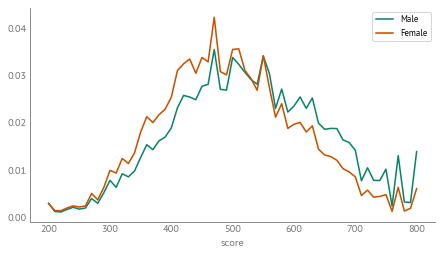

In [16]:
pmf = counts_male.copy()
pmf.normalize()
pmf.plot(label='Male')

pmf = counts_female.copy()
pmf.normalize()
pmf.plot(label='Female')

decorate()

In [17]:
# prepare the data
counts = counts_male
observed_counts = counts.reindex(thetas, fill_value=0).to_numpy()
observed_counts

array([ 2456,  1071,   995,  1426,  1779,  1461,  1655,  3237,  2445,
        4219,  6291,  5119,  7392,  6874,  7849, 10125, 12256, 11435,
       12907, 13540, 15086, 18432, 20513, 20246, 19797, 22055, 22375,
       28202, 21529, 21407, 26878, 25713, 24384, 23170, 22386, 27114,
       24149, 18336, 21576, 17727, 18733, 20261, 18349, 20075, 15874,
       14840, 14988, 14965, 13058, 12623, 11344,  6226,  8388,  6285,
        6259,  8155,  2004, 10434,  2673,  2563, 11098])

In [18]:
N_test_obs = int(observed_counts.sum())

# Assuming for now that half of all high school seniors took the test
N_total = N_test_obs * 2
N_total, N_test_obs

(1589604, 794802)

In [19]:
import pytensor.tensor as pt 

with pm.Model() as model:
    # Latent population score distribution
    mu = pm.Normal("mu", mu=500, sigma=30)
    sigma = pm.Gamma("sigma", alpha=20, beta=0.2)

    # Compute population distribution (normalized logpdf)
    logp_vals = pm.logp(pm.Normal.dist(mu=mu, sigma=sigma), full_thetas)
    log_noise = pm.Normal("log_noise", mu=0.0, sigma=0.02, shape=logp_vals.shape)

    perturbed_logp = logp_vals + log_noise
    logp_normalizer = pm.math.logsumexp(perturbed_logp)
    pop_pdf = pm.math.exp(perturbed_logp - logp_normalizer)
    
    left_mass = pop_pdf[left_mask].sum()
    right_mass = pop_pdf[right_mask].sum()
    center_pdf = pop_pdf[center_mask]
    
    center_pdf = pt.set_subtensor(center_pdf[0], center_pdf[0] + left_mass)
    center_pdf = pt.set_subtensor(center_pdf[-1], center_pdf[-1] + right_mass)

    # Selection model: logistic function
    alpha = pm.Normal("alpha", mu=0, sigma=0.1)
    beta = pm.Normal("beta", mu=0, sigma=0.01)

    logits = alpha + beta * thetas_centered / 100
    p_take = pm.Deterministic("p_take", pm.math.sigmoid(logits))

    # Test-taker score distribution
    test_unnorm = center_pdf * p_take
    prob_test = pm.math.sum(test_unnorm)
    test_pdf = test_unnorm / pm.math.sum(test_unnorm)

    # Binomial likelihood for number of test-takers
    pm.Binomial("N_test", n=N_total, p=prob_test, observed=N_test_obs)

    # Multinomial likelihood for binned scores
    pm.Multinomial("obs_bins", n=N_test_obs, p=test_pdf, observed=observed_counts)

    idata = pm.sample_prior_predictive(1000)

Sampling: [N_test, alpha, beta, log_noise, mu, obs_bins, sigma]


In [20]:
with model:
    idata = pm.sample(target_accept=0.8)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, log_noise, alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [21]:
pm.summary(idata, var_names=['mu', 'sigma', 'alpha', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,530.145,0.744,528.731,531.540,0.017,0.013,1901.0,2129.0,1.0
sigma,123.201,0.166,122.894,123.508,0.004,0.002,2046.0,2694.0,1.0
alpha,0.001,0.003,-0.005,0.007,0.000,0.000,2123.0,2366.0,1.0
beta,-0.003,0.010,-0.021,0.014,0.000,0.000,1960.0,2026.0,1.0


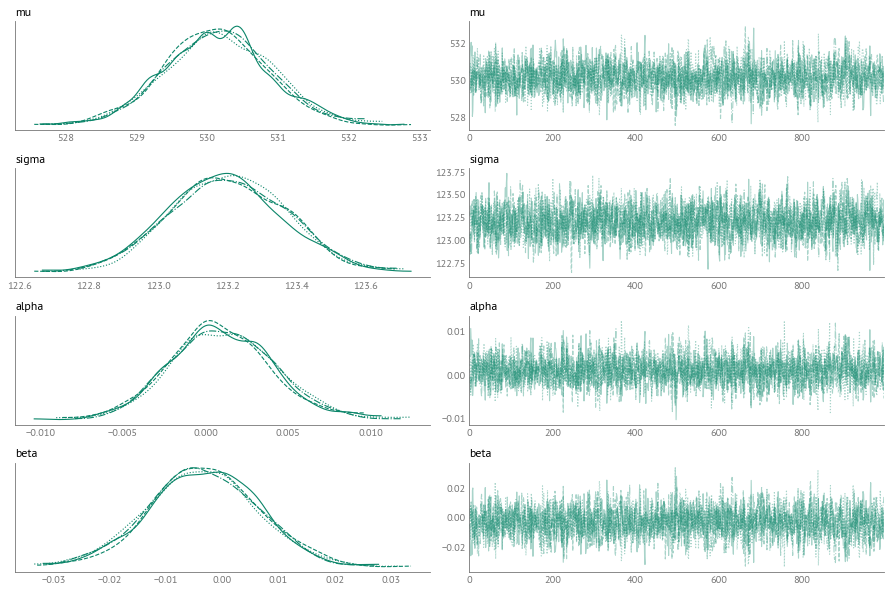

In [22]:
pm.plot_trace(idata, var_names=['mu', 'sigma', 'alpha', 'beta'])
decorate()

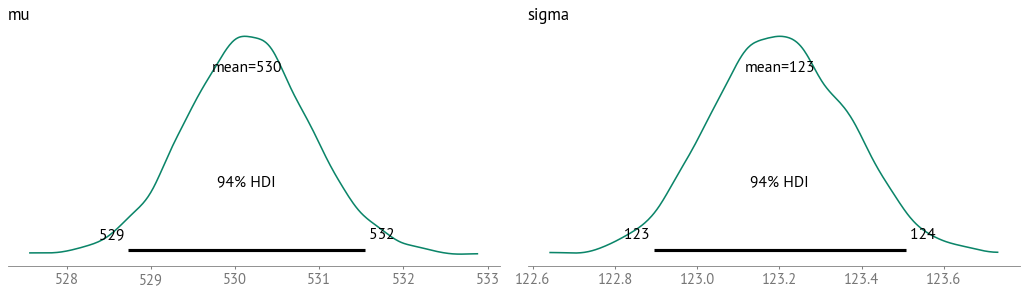

In [23]:
pm.plot_posterior(idata, var_names=['mu', 'sigma'])
decorate()

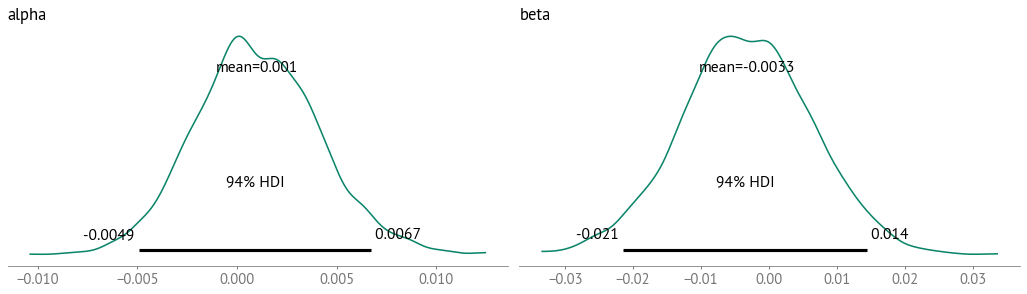

In [24]:
pm.plot_posterior(idata, var_names=['alpha', 'beta'])
decorate()

array([<Axes: title={'left': '94.0% HDI'}>], dtype=object)

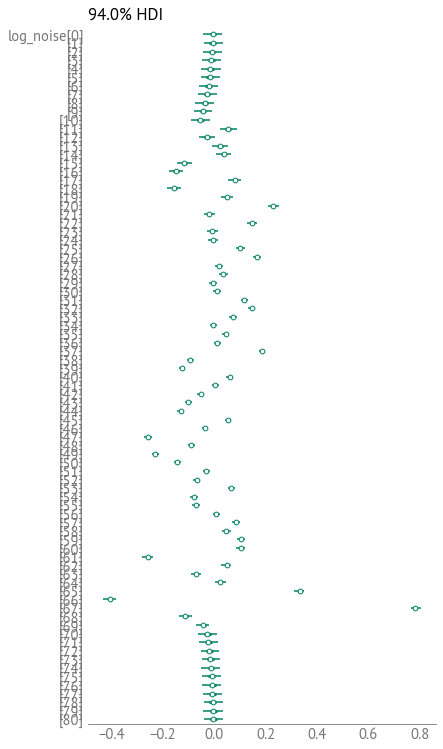

In [25]:
az.plot_forest(idata, var_names='log_noise', combined=True)

In [26]:
def plot_selection_function(idata, col, thetas_centered, **options):
    thetas_xr = xr.DataArray(thetas_centered, dims="theta", coords={"theta": thetas})

    # Extract posterior samples of alpha and beta ---
    posterior = idata.posterior  # shape (chain, draw)

    # Compute logits and apply sigmoid ---
    logits = posterior["alpha"] + posterior["beta"] * thetas_xr
    p = xr.apply_ufunc(expit, logits)

    # Compute median and HDI ---
    median_curve = p.median(dim=["chain", "draw"])
    hdi_bounds = az.hdi(p, hdi_prob=0.94)
    low, high = hdi_bounds['x'].T

    # Plot ---
    plt.plot(thetas, median_curve, **options)
    plt.fill_between(
        thetas,
        low,
        high,
        alpha=0.3,
    )    

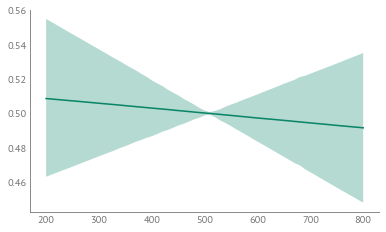

In [27]:
plot_selection_function(idata, 'sat_math', thetas_scaled)

## Hierarchical

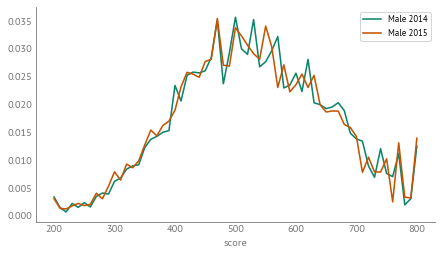

In [28]:
pmf = get_counts(sat_2014, 0)
pmf.normalize()
pmf.plot(label='Male 2014')

pmf = get_counts(sat_2015, 0)
pmf.normalize()
pmf.plot(label='Male 2015')

decorate()

In [29]:
def get_observed_counts(sat, sex):
    counts = get_counts(sat, sex)
    observed_counts = counts.reindex(thetas, fill_value=0).to_numpy()
    return observed_counts

counts_male_2014 = get_observed_counts(sat_2014, sex=0)
counts_male_2015 = get_observed_counts(sat_2015, sex=0)
counts_female_2014 = get_observed_counts(sat_2014, sex=1)
counts_female_2015 = get_observed_counts(sat_2015, sex=1)

data = np.stack([
    [counts_male_2014, counts_female_2014],   # year 2014
    [counts_male_2015, counts_female_2015],   # year 2015
])

n_years, n_sexes, n_scores = data.shape
print(data.shape)  # (2, 2, n_scores)

(2, 2, 61)


In [30]:
data.sum(axis=2)

array([[783570, 888825],
       [794802, 903719]])

In [31]:
N_test_obs = data.sum(axis=2)

# Assuming for now that half of all high school seniors took the test
N_total = N_test_obs * 2
N_total, N_test_obs

(array([[1567140, 1777650],
        [1589604, 1807438]]),
 array([[783570, 888825],
        [794802, 903719]]))

In [32]:
import pytensor

pytensor.config.exception_verbosity = "high"

In [34]:
import pytensor.tensor as pt 

coords = {
    'year': [2014, 2015],
    'sex': ['male', 'female'],
    'full_score': full_thetas,  # 81
    'score': thetas_centered,     # 61
}

thetas_scaled = thetas_centered[None, None, :] / 30

with pm.Model(coords=coords) as model:
    # Data
    data_pt = pm.Data("data", data, dims=("year", "sex", "score"))
    N_test_obs_pt = pm.Data("N_test_obs", N_test_obs, dims=("year", "sex"))
    N_total_pt = pm.Data("N_total", N_total, dims=("year", "sex"))

    # Latent population score distribution
    mu = pm.Normal("mu", mu=500, sigma=30, dims='sex')
    sigma = pm.Gamma("sigma", alpha=20, beta=0.2, dims='sex')

    # Compute population distribution (normalized logpdf)
    mu_b = mu[:, None]
    sigma_b = sigma[:, None]
    theta_b = full_thetas[None, :]

    logp_vals = pm.logp(pm.Normal.dist(mu=mu_b, sigma=sigma_b), theta_b) # sex, score
    log_noise = pm.Normal("log_noise", mu=0.0, sigma=0.02, dims=['year', 'full_score'])

    perturbed_logp = logp_vals[None, :, :] + log_noise[:, None, :]
    logp_normalizer = pm.math.logsumexp(perturbed_logp, axis=-1, keepdims=True)
    pop_pdf = pm.math.exp(perturbed_logp - logp_normalizer)
    
    # collect tail mass per (year, sex)
    left_mass = pop_pdf[:, :, left_mask].sum(axis=-1)   # shape (year, sex)
    right_mass = pop_pdf[:, :, right_mask].sum(axis=-1) # shape (year, sex)

    # slice out the center scores
    center_pdf = pop_pdf[:, :, center_mask]             # shape (year, sex, n_center)

    # add tail mass into the first and last bins
    center_pdf = pt.set_subtensor(center_pdf[:, :, 0],  center_pdf[:, :, 0]  + left_mass)
    center_pdf = pt.set_subtensor(center_pdf[:, :, -1], center_pdf[:, :, -1] + right_mass)

    # Selection model: logistic function
    alpha = pm.Normal("alpha", mu=0, sigma=0.1, dims=['year', 'sex'])
    beta = pm.Normal("beta", sigma=0.01, dims=['year', 'sex'])

    logits = alpha[:, :, None] + beta[:, :, None] * thetas_scaled
    p_take = pm.Deterministic("p_take", pm.math.sigmoid(logits))

    # Test-taker score distribution
    test_unnorm = center_pdf * p_take
    prob_test = pm.math.sum(test_unnorm, axis=-1)
    test_pdf = test_unnorm / pm.math.sum(test_unnorm, axis=-1, keepdims=True)

    # Binomial likelihood for number of test-takers
    pm.Binomial("N_test", n=N_total_pt, p=prob_test, observed=N_test_obs_pt)

    # Multinomial likelihood for binned scores
    pm.Multinomial("obs_bins", n=N_test_obs_pt, p=test_pdf, observed=data_pt)

    idata = pm.sample_prior_predictive(1000)

Sampling: [N_test, alpha, beta, log_noise, mu, obs_bins, sigma]


TODO: Save traces for male and female, 2014 and 2015

In [35]:
with model:
    idata = pm.sample(target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, log_noise, alpha, beta]


Output()

/home/downey/miniconda3/envs/SelectionSAT/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 131 seconds.


In [36]:
pm.summary(idata, var_names=['mu', 'sigma', 'alpha', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[male],525.995,1.333,523.557,528.503,0.032,0.020,1769.0,2028.0,1.0
mu[female],514.951,1.314,512.637,517.522,0.036,0.023,1354.0,1906.0,1.0
sigma[male],122.009,0.140,121.739,122.268,0.004,0.002,1558.0,1964.0,1.0
sigma[female],114.760,0.167,114.443,115.068,0.004,0.003,1413.0,1857.0,1.0
"alpha[2014, male]",-0.022,0.003,-0.027,-0.015,0.000,0.000,1970.0,2363.0,1.0
"alpha[2014, female]",0.020,0.005,0.011,0.030,0.000,0.000,1431.0,1907.0,1.0
"alpha[2015, male]",-0.017,0.003,-0.023,-0.011,0.000,0.000,1936.0,2173.0,1.0
"alpha[2015, female]",0.018,0.005,0.010,0.028,0.000,0.000,1441.0,1905.0,1.0
"beta[2014, male]",0.030,0.005,0.019,0.040,0.000,0.000,1701.0,2023.0,1.0
"beta[2014, female]",-0.056,0.006,-0.067,-0.044,0.000,0.000,1334.0,1663.0,1.0


array([<Axes: title={'left': '94.0% HDI'}>], dtype=object)

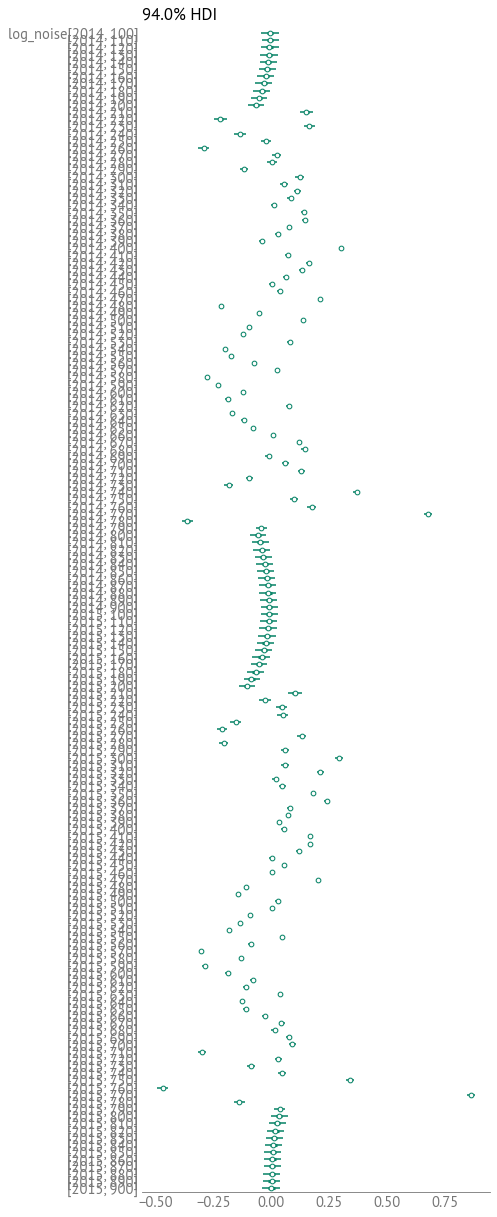

In [37]:
az.plot_forest(idata, var_names='log_noise', combined=True)

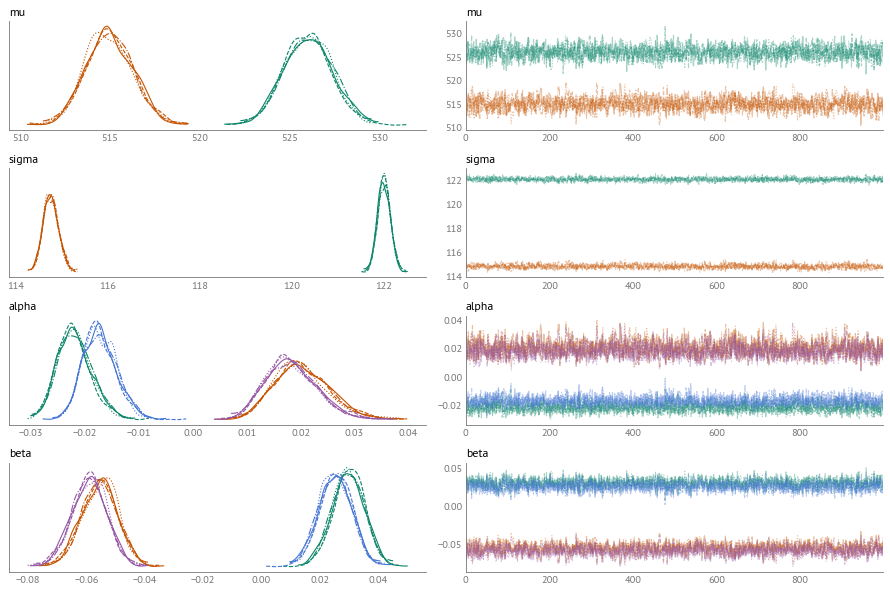

In [38]:
pm.plot_trace(idata, var_names=['mu', 'sigma', 'alpha', 'beta'])
decorate()

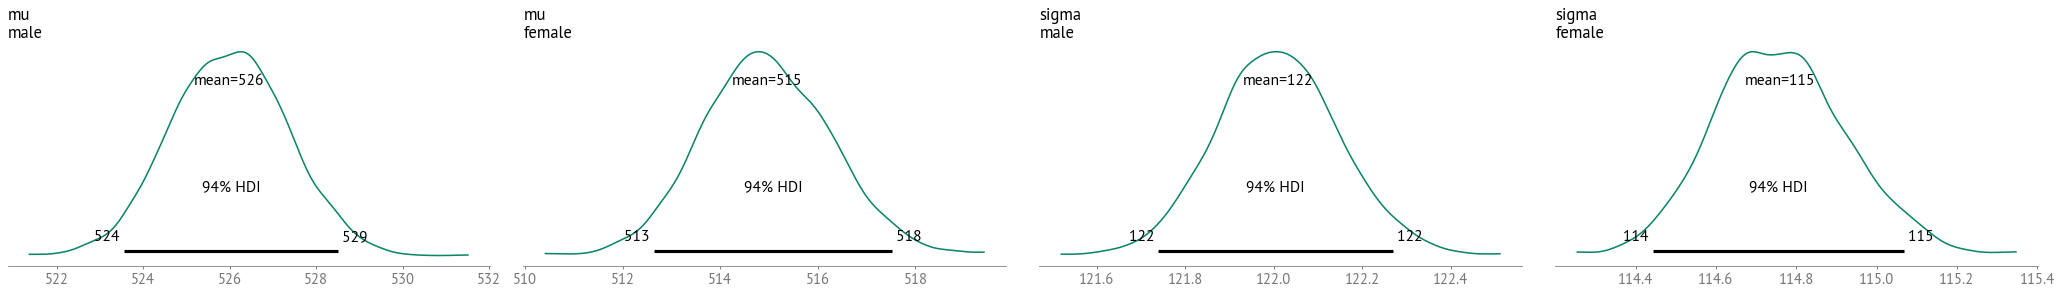

In [39]:
pm.plot_posterior(idata, var_names=['mu', 'sigma'])
decorate()

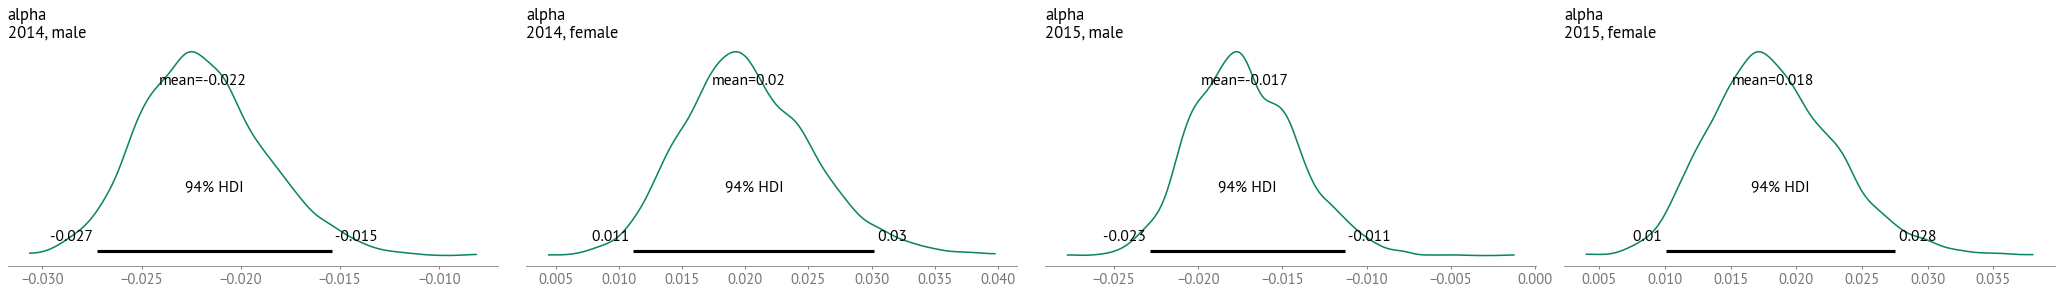

In [40]:
pm.plot_posterior(idata, var_names=['alpha'])
decorate()

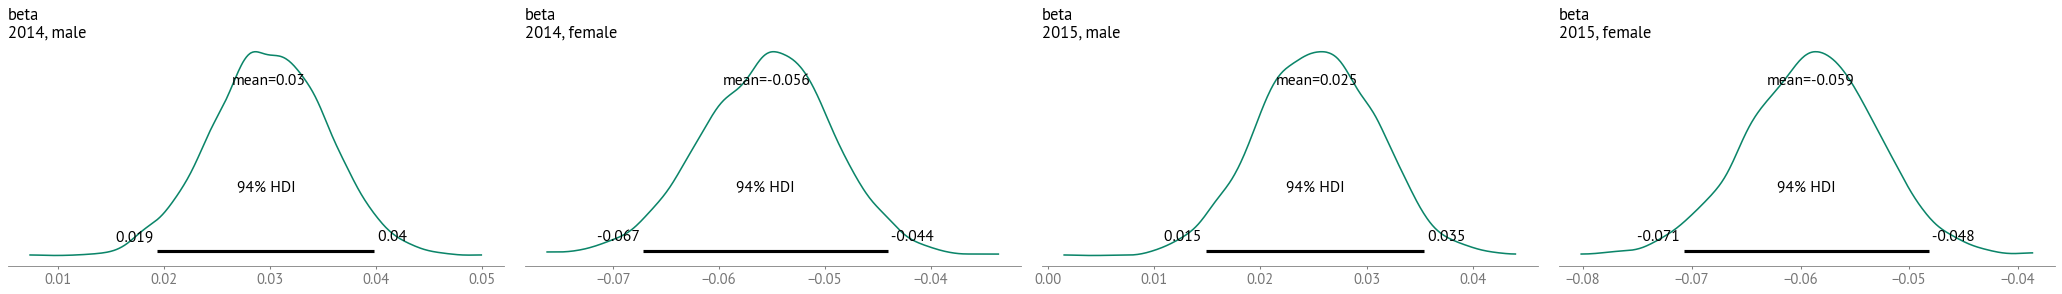

In [41]:
pm.plot_posterior(idata, var_names=['beta'])
decorate()

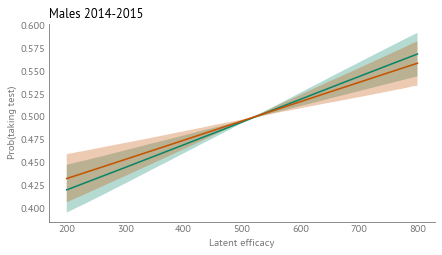

In [49]:
for year in [2014, 2015]:
    idata_one = idata.sel(year=year, sex="male")
    plot_selection_function(idata_one, None, thetas_centered / 30)
    
decorate(xlabel='Latent efficacy', ylabel='Prob(taking test)', title='Males 2014-2015')

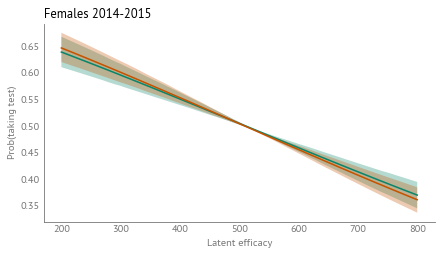

In [50]:
for year in [2014, 2015]:
    idata_one = idata.sel(year=year, sex="female")
    plot_selection_function(idata_one, None, thetas_centered / 30)
    
decorate(xlabel='Latent efficacy', ylabel='Prob(taking test)', title='Females 2014-2015')

In [ ]:
stop

In [ ]:
# OLD VERSION WITH JUST YEAR AND SCORE

import pytensor.tensor as pt 

coords = {
    'year': [2014, 2015],
    'score': full_thetas,
}

with pm.Model(coords=coords) as model:
    # Latent population score distribution
    mu = pm.Normal("mu", mu=500, sigma=30)
    sigma = pm.Gamma("sigma", alpha=20, beta=0.2)

    # Compute population distribution (normalized logpdf)
    logp_vals = pm.logp(pm.Normal.dist(mu=mu, sigma=sigma), full_thetas)
    log_noise = pm.Normal("log_noise", mu=0.0, sigma=0.02, dims='score')
    
    perturbed_logp = logp_vals + log_noise
    logp_normalizer = pm.math.logsumexp(perturbed_logp)
    pop_pdf = pm.math.exp(perturbed_logp - logp_normalizer)
    
    left_mass = pop_pdf[:, left_mask].sum(axis=1)    # shape: (sex,)
    right_mass = pop_pdf[:, right_mask].sum(axis=1)  # shape: (sex,)
    center_pdf = pop_pdf[:, center_mask]             # shape: (sex, center_len)

    # Add tail masses to first and last score bins for each sex
    center_pdf = pt.set_subtensor(center_pdf[:, 0], center_pdf[:, 0] + left_mass)
    center_pdf = pt.set_subtensor(center_pdf[:, -1], center_pdf[:, -1] + right_mass)

    # Selection model: logistic function
    alpha = pm.Normal("alpha", mu=0, sigma=0.1, dims='year')
    beta = pm.Normal("beta", sigma=0.01, dims='year')

    logits = alpha[:, None] + beta[:, None] * thetas_scaled
    p_take = pm.Deterministic("p_take", pm.math.sigmoid(logits))

    # Test-taker score distribution
    test_unnorm = center_pdf * p_take
    prob_test = pm.math.sum(test_unnorm, axis=1)
    test_pdf = test_unnorm / pm.math.sum(test_unnorm, axis=1, keepdims=True)

    # Binomial likelihood for number of test-takers
    pm.Binomial("N_test", n=N_total, p=prob_test, observed=N_test_obs)

    # Multinomial likelihood for binned scores
    pm.Multinomial("obs_bins", n=N_test_obs, p=test_pdf, observed=data)

    #idata = pm.sample_prior_predictive(1000)